# 1. Практическое задание. Обучение полносвязной нейронной сети.

**ФИО**: Алексеев Илья Алексеевич

**Дедлайн**: 09 октября 2020

In [1]:
import numpy as np
import torch
import cv2

from glob import glob
from collections import OrderedDict
from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Function
from torch.autograd import gradcheck
from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms

## 1. Загрузка данных

Если вам требуется работать с каким-нибубь набором данных (dataset), то прежде всего проверьте нет ли его среди встроенных наборов данных https://pytorch.org/vision/stable/datasets.html.

В текущем домашнем задании мы будем работать с набором данных FashionMNIST. Он присутствует в списке встроенных наборов данных, однако мы воспользуемся реализацией только для удобного и быстрого способа скачать наборы данных. Ниже предлагается реализовать собственный класс для считывания, обработки и упаковки данных.

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True
)

Воспользуемся функцией загрузки данных из репозитория наборов данных.

In [3]:
! ls data/FashionMNIST/raw

t10k-images-idx3-ubyte	   train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte	   train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [4]:
#https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [5]:
images, labels = load_mnist('data/FashionMNIST/raw')
images.shape, labels.shape

((60000, 784), (60000,))

Для удобства PyTorch предоставляет ряд базовых классов `Dataset, DataLoader`, от которых предлагается отнаследоваться при разработке пользовательских классов. Базовый класс `Dataset` используется для загрузки и обработки данных, класс `DataLoader` используется для управления процессом загрузки данных, позволяет в многопоточном режиме загружать данные и упаковывать их.
Эти вспомогательные классы находятся в модуле `torch.utils.data`.

При наследовании от класса `torch.utils.data.Dataset` требуется переопределить метод `__len__`, который возвращает количество примеров в наборе данных, а также метод `__getitem__`, который позволяет получить доступ к примеру из набора данных по индексу.

Реализуем класс для FasionMnist.

Элементами датасета должны являться пары '(np.array, int)', массив имеет размерность `(28, 28)`, тип элемента `np.float32`.

In [6]:
import os

class FashionMnist(Dataset):
    def __init__(self, path, train=True, image_transform=None,
                 label_transform=None):
        if train:
            images, labels = load_mnist(os.path.join(path,"raw"))
        else:
            images, labels = load_mnist(os.path.join(path,"raw"), kind="t10k")

        images = np.reshape(images, (-1, 28, 28))

        if image_transform is not None:
            images = image_transform(images)
        if label_transform is not None:
            labels = label_transform(labels)
        
        self.images = images
        self.labels = labels

    def __len__(self,):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        return img, label


In [7]:
test_dataset = FashionMnist("data/FashionMNIST", train=False)
train_dataset = FashionMnist("data/FashionMNIST")

Визуализируйте случайные элементы набора данных.

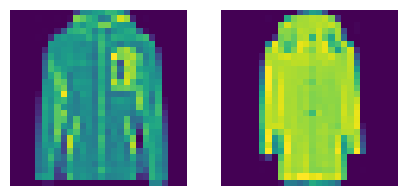

In [8]:
# np.random.seed(0)

def show_random_img(dataset, ax):
    i_img = np.random.randint(0, len(train_dataset))
    img, _ = train_dataset[i_img]
    ax.imshow(img)
    ax.axis('off')

fig, ax = plt.subplots(1, 2, figsize=(5,5))
show_random_img(train_dataset, ax[0])
show_random_img(test_dataset, ax[1])

В конструктор `Dataset` можно передать объект `torchvision.transforms`, который позволяет преобразовать исходные данные. Преобразование `torchvision.transforms.ToTensor` позволяет преобразоать данные из типа `PIL Image` и `numpy.float32` в тип `torch.float32`

Реализуйте собственную поддержку преобразований в `FashionMnist`. Проверьте, что приведение типов работает корректно.

In [9]:
class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return torch.from_numpy(sample.copy())

class ToFloat:
    def __call__(self, x):
        return x.float()

class ToLong:
    def __call__(self, x):
        return x.long()

In [10]:
image_transform = transforms.Compose([
    ToTensor(),
    ToFloat()
])
label_transform = transforms.Compose([
    ToTensor(),
    ToLong()
])

test_dataset = FashionMnist("data/FashionMNIST",
                            train=False,
                            image_transform=image_transform,
                            label_transform=label_transform
                            )
train_dataset = FashionMnist("data/FashionMNIST",
                             image_transform=image_transform,
                             label_transform=label_transform
                             )

In [11]:
print(f"The type of the data is {type(test_dataset[0][0])}")

The type of the data is <class 'torch.Tensor'>


Элементы набора данных могут быть объединены в пакеты (batch) явно и неявно. Если данные могут быть сконкатенированы или обЪединены каким-нибудь тривиальным способом, то можно не передавать никаких дополнительных парамертов в `torch.utils.data.Dataloader`.

In [12]:
test_dataloader = DataLoader(test_dataset, batch_size=64, num_workers=12, shuffle=True)
batch = next(iter(test_dataloader))

In [13]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")
print(f"The shape of the batch[1] is {batch[1].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([64, 28, 28])
The shape of the batch[1] is torch.Size([64])


Однако, если наша структура данных не позволяет нам использовать объединение по умолчанию, то можно написать собственную функцию, которая будет пакетировать данные.

Реализуйте функцию, преобразующую последовательность элементов массива в пакет (batch).

In [14]:
def collate(batch):
    imgs = []
    labels = []
    for img, lab in batch:
        imgs.append(img)
        labels.append(lab)
    imgs = torch.stack(imgs, dim=0)
    labels = torch.stack(labels)
    return imgs, labels

Убедитесть, что все работает корректно.

In [15]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2,
                             shuffle=True, collate_fn=collate)
train_dataloader = DataLoader(train_dataset, batch_size=15, num_workers=2,
                              shuffle=True, collate_fn=collate)
batch = next(iter(test_dataloader))

In [16]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")
print(f"The shape of the batch[1] is {batch[1].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])
The shape of the batch[1] is torch.Size([15])


## 2. Реализация модулей нейронной сети (15 баллов)

В этом разделе мы полностью реализуем модули для полносвязанной сети.

Для начала нам понадобится реализовать прямой и обратный проход через слои.

Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

Сначала, мы реализуем функцию и её градиент.

In [17]:
class IdentityFunction(Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        return input

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        return grad_output

Разработанную функцию обернем классом `IdentityLayer`, все слои в `PyTorch` должны быть наследниками базового класса `nn.Module()`


In [18]:
class IdentityLayer(nn.Module):
    def __init__(self):
        # An identity layer does nothing
        super().__init__()
        self.identity = IdentityFunction.apply

    def forward(self, inp):
        # An identity layer just returns whatever it gets as input.
        return self.identity(inp)


### 2.1 Функция активации ReLU
Для начала реализуем функцию активации, слой нелинейности `ReLU(x) = max(x, 0)`. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения `ReLU` к входному массиву, метод `backward` - градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить в `ctx`.

In [19]:
class ReLUFunction(Function):
    @staticmethod
    def forward(ctx, input):
        mask = input > 0
        output = torch.where(mask, input, 0)
        ctx.save_for_backward(mask)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        mask, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[~mask] = 0
        return grad_input

In [20]:
class ReLU(nn.Module):
    def __init__(self):
        super().__init__()

        self.fn = ReLUFunction.apply

    def forward(self, input):
        return self.fn(input)

Не забываем после реализации функции проверить градиент, испльзуя функцию `gradcheck`.

In [21]:
relu = ReLUFunction.apply
x = torch.randn(4, 4, requires_grad=True, dtype=torch.double)

print(x, relu(x))

assert gradcheck(relu, x)

tensor([[-0.7379, -0.5384,  0.6955,  0.2269],
        [ 0.4056, -0.0441, -0.0136, -0.3573],
        [ 0.1937,  0.7880,  1.0764,  0.3741],
        [ 0.0258, -0.7210,  0.1712,  0.1223]], dtype=torch.float64,
       requires_grad=True) tensor([[0.0000, 0.0000, 0.6955, 0.2269],
        [0.4056, 0.0000, 0.0000, 0.0000],
        [0.1937, 0.7880, 1.0764, 0.3741],
        [0.0258, 0.0000, 0.1712, 0.1223]], dtype=torch.float64,
       grad_fn=<ReLUFunctionBackward>)


In [22]:
assert torch.norm(torch.nn.functional.relu(x.float()) - relu(x)) < 1e-5

### 2.2 Линейный слой (linear, fully-connected)
Далее реализуем полносвязный слой без нелинейности. У слоя два набора параметра: матрица весов (weights) и вектор смещения (bias).

In [23]:
class LinearFunction(Function):
    @staticmethod
    def forward(ctx, inp, weight, bias):
        """
        inp: (B, in_features)
        weight: (out_features, in_features)
        bias: (out_features,)
        """
        ctx.save_for_backward(inp, weight)
        output = inp.matmul(weight.T).add(bias)
        return output
    @staticmethod
    def backward(ctx, grad_output):
        inp, weight = ctx.saved_tensors
        grad_input = grad_output.matmul(weight)
        grad_weight = grad_output.T.matmul(inp)
        grad_bias = grad_output.sum(dim=0)
        return grad_input, grad_weight, grad_bias

In [24]:
import math
from torch.nn import Parameter

class Linear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()

        self.in_features = in_features
        self.out_features = out_features

        self.weight = Parameter(torch.empty(out_features, in_features))
        self.bias = Parameter(torch.empty(out_features))
        self.reset_parameters()
        
        self.fn = LinearFunction.apply

    def reset_parameters(self):
        std = math.sqrt(2 / self.in_features)
        torch.nn.init.normal_(self.weight, mean=0, std=std)
        torch.nn.init.normal_(self.bias, mean=0, std=std)

    def forward(self, inp):
        return self.fn(inp, self.weight, self.bias)

Проверим градиент, а также сравним с работой нашего модуля с имплементированным в `PyTorch`.

Проверка градиента:

In [25]:
in_features = 4
out_features = 16
batch_size = 64

linear = Linear(in_features, out_features)
x = torch.randn(batch_size, in_features, requires_grad=True, dtype=torch.double)

assert gradcheck(LinearFunction.apply, [x, linear.weight.double(), linear.bias.double()])

Сравнение с `PyTorch`.

In [26]:
torch_linear = torch.nn.Linear(in_features, out_features)
our_linear = Linear(in_features, out_features)

state_dict = OrderedDict([("weight", linear.weight), ("bias", linear.bias)])
torch_linear.load_state_dict(state_dict)
our_linear.load_state_dict(state_dict)

x = x.float()
assert torch.norm(torch_linear(x) - our_linear(x)) < 1e-5

### 2.3 LogSoftmax (Log + Softmax)

Для решения задачи многоклассовой классификации обычно используют `softmax` в качестве нелинейности на последнем слое, чтобы получить "оценку" вероятности классов для каждого объекта:$$\hat y = softmax(x)  = \bigl \{\frac {exp(x_i)}{\sum_j exp(x_j)} \bigr \}_{i=1}^K, \quad K - \text{число классов}$$В этом случае удобно оптимизировать логарифм правдоподобия:$$L(y, \hat y) = -\sum_{i=1}^K y_i \log \hat y_i \rightarrow \min,$$где $y_i=1$, если объект принадлежит $i$-му классу, и 0 иначе. Записанная в таком виде, эта функция потерь совпадает с выражением для кросс-энтропии. Очевидно, что ее также можно переписать через индексацию, если через $y_i$ обозначить класс данного объекта:$$L(y, \hat y) = - \log \hat y_{y_i} \rightarrow \min$$В таком виде ее удобно реализовывать.

Реализуйте слой `LogSoftmax` (без параметров). Метод `forward` должен вычислять логарифм от `softmax`, а метод `backward` - пропускать градиенты. В общем случае в промежуточных вычислениях `backward` получится трехмерный тензор, однако для нашей конкретной функции потерь все вычисления можно реализовать в матричном виде. Поэтому мы будем предполагать, что аргумент `grad_output` - это матрица, у которой в каждой строке только одно ненулевое значение (не обязательно единица).

Комментарий: разобраться `Log-Sum-Exp trick`

In [27]:
class LogSoftmaxFunction(Function):
    @staticmethod
    def forward(ctx, inp):
        """
        inp: (B, n_features)
        """
        output = inp - torch.logsumexp(inp, dim=1, keepdim=True)
        ctx.save_for_backward(output)
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        output, = ctx.saved_tensors
        grad_input = grad_output - grad_output.sum(dim=1, keepdim=True) * torch.exp(output)
        return grad_input

In [28]:
class LogSoftmax(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fn = LogSoftmaxFunction.apply

    def forward(self, input):
        return self.fn(input)

Проверка градиентов.

In [29]:
x = torch.randn(batch_size, in_features, requires_grad=True, dtype=torch.double)
fn = LogSoftmax()

assert gradcheck(fn, x)

Сравнение с торчем

In [30]:
torch.norm(torch.nn.functional.log_softmax(x, dim=1) - fn(x))

tensor(2.8978e-15, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)

### 2.4 Dropout
Реализуйте слой Dropout.

In [31]:
class DropoutFunction(Function):
    @staticmethod
    def forward(ctx, inp, p, training):
        """
        inp: (B, features)
        p: float from (0, 1)
        training: True = train mode, False = inference mode
        """
        ctx.training = training
        
        if not training:
            return inp

        mask = torch.rand_like(inp) < p
        ctx.save_for_backward(mask)
        ctx.p = p

        output = inp.clone()
        output[mask] = 0
        output[~mask] /= 1 - p

        return output

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()

        if not ctx.training:
            return grad_input

        mask, = ctx.saved_tensors
        
        grad_input[mask] = 0
        grad_input[~mask] /= 1 - ctx.p

        return grad_input, None, None

In [32]:
class Dropout(nn.Module):
    def __init__(self, p):
        super().__init__()
        
        self.p = p
        self.fn = DropoutFunction.apply

    def forward(self, input):
        return self.fn(input, self.p, self.training)

In [33]:
x = torch.randn(3, requires_grad=True, dtype=torch.double)

p = 0.5
drop = Dropout(p=p)

print(drop(x))

tensor([-1.9534,  1.8536,  0.0000], dtype=torch.float64,
       grad_fn=<DropoutFunctionBackward>)


### 2.5 CrossEntropy

При решении задачи многоклассовой классификации мы будет использовать в качестве функции потерь кроссэнтропию. Реализуйте функцию потерь. В разделе 2.3 приведены полезные формулы.

In [34]:
class CrossEntropyFunction(Function):
    @staticmethod
    def forward(ctx, activations: torch.Tensor, target, reduction='none'):
        ctx.save_for_backward(activations, target)
        ctx.reduction = reduction

        indices = torch.arange(len(target), device=activations.device)
        
        nll = activations[indices, target].neg()
        if reduction == 'sum':
            nll = nll.sum()
        elif reduction == 'mean':
            nll = nll.mean()
        
        return nll

    @staticmethod
    def backward(ctx, grad_output):
        activations, target = ctx.saved_tensors
        
        grad_output_clone = grad_output.clone()
        grad_input = torch.zeros_like(activations)
        grad_input[torch.arange(len(target)), target] = grad_output_clone.neg()

        if ctx.reduction == 'mean':
            grad_input /= len(target)

        return grad_input, None, None


class CrossEntropy(nn.Module):
    def __init__(self, reduction='none'):
        super().__init__()
        
        self.reduction = reduction
        self.fn = CrossEntropyFunction.apply

    def forward(self, activations, target):
        return self.fn(activations, target, self.reduction)

Проверка градиентов.

In [35]:
batch_size = 64
n_classes = 10

activations = torch.randn(batch_size, n_classes, requires_grad=True, dtype=torch.double)
target = torch.randint(low=0, high=n_classes, size=(batch_size,))

assert gradcheck(CrossEntropy(reduction='none'), [activations, target])
assert gradcheck(CrossEntropy(reduction='mean'), [activations, target])
assert gradcheck(CrossEntropy(reduction='sum'), [activations, target])

## 3. Сборка и обучение нейронной сети (5 балла)

Реализуйте произвольную нейросеть, состоящую из ваших блоков. Она должна состоять из нескольких полносвязанных слоев.

In [36]:
class Network(nn.Module):
    def __init__(
        self,
        input_size=28*28,
        hidden_size=32,
        n_hidden_layers=1,
        n_classes=10,
        dropout_prob=0.05
    ):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_hidden_layers = n_hidden_layers
        self.n_classes = n_classes

        self.input_layer = Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([Linear(hidden_size, hidden_size) for _ in range(n_hidden_layers)])
        self.drop = nn.ModuleList([Dropout(dropout_prob) for _ in range(n_hidden_layers)])
        self.output_layer = Linear(hidden_size, n_classes)

        self.act_fn = ReLU()
        self.log_softmax = LogSoftmax()

    def forward(self, x):
        x = x.reshape(len(x), -1)
        x = self.act_fn(self.input_layer(x))
        for layer, drop in zip(self.hidden_layers, self.drop):
            x = self.act_fn(layer(drop(x)))
        x = self.output_layer(x)
        x = self.log_softmax(x)
        return x

    def predict(self, x):
        logits = self(x)
        pred_labels = torch.argmax(logits, dim=1)
        return pred_labels

Ниже приведены функции, реализующие обучение нейронной сети. В данном задании их предлагается просто переиспользовать.

In [37]:
class EmptyContext:
    def __enter__(self):
        pass

    def __exit__(self, *args):
        pass

In [38]:
# accuract metric for our classififcation
def accuracy(model_labels, labels):
  return (model_labels == labels).float().mean().detach().cpu().item()

In [39]:
def perform_epoch(model, loader, criterion,
                optimizer=None, device=None):
    is_train = optimizer is not None
    model = model.to(device)
    if is_train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    total_acc = 0
    total_n = 0
    with EmptyContext() if is_train else torch.no_grad():
        for batch_data, batch_labels in loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            model_logits = model(batch_data)
            model_prediction = model.predict(batch_data)
            new_loss = criterion(model_logits, batch_labels)
            if is_train:
              optimizer.zero_grad()
              new_loss.backward()
              optimizer.step()

            one_batch_loss = float(criterion(model_logits, batch_labels))
            one_batch_acc = accuracy(model_prediction, batch_labels)

            total_loss += one_batch_loss
            total_acc += one_batch_acc
            total_n += 1
    return (total_loss / total_n, total_acc / total_n)

Теперь обучим нашу нейронную сеть. В данном разделе будем использовать оптимизатор `Adam` с параметрами по умолчанию.

In [40]:
model     = Network()
optimizer = Adam(model.parameters(), lr=5e-4)
criterion = CrossEntropy(reduction='mean')

In [41]:
img, lab = next(iter(train_dataloader))
img.shape, lab.shape

(torch.Size([15, 28, 28]), torch.Size([15]))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(10):
    loss, acc = perform_epoch(
        model,
        train_dataloader,
        criterion,
        optimizer=optimizer,
        device=device
    )
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

In [43]:
print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 9 : loss 0.9725141463838518, accuracy 0.6062666949443519
Current learning rate: 0.0005


Дальше:
- Проведите эксперименты с числом слоев.
- Постройте графики зависимости качества модели на тренировочной и тестовой выборках от числа слоев. Для получения статистически значимых результатов повторите эксперименты несколько раз.
- Сделайте выводы.

### Число слоев

In [44]:
from collections import defaultdict
from tqdm.autonotebook import tqdm

def n_layers_experiment(n_hidden_layers, device, hidden_size):
    model = Network(n_hidden_layers=n_hidden_layers, hidden_size=hidden_size)
    model.to(device)
    optimizer = Adam(model.parameters(), lr=5e-4)
    criterion = CrossEntropy(reduction='mean')

    res = defaultdict(list)

    for i_epoch in tqdm(range(10), desc='epoch'):
        loss, acc = perform_epoch(
            model,
            train_dataloader,
            criterion,
            optimizer=optimizer,
            device=device
        )
        res['train_loss'].append(loss)
        res['train_acc'].append(acc)
        loss, acc = perform_epoch(
            model,
            test_dataloader,
            criterion,
            optimizer=None,
            device=device
        )
        res['test_loss'].append(loss)
        res['test_acc'].append(acc)
        res['i_epoch'].append(i_epoch)
        res['n_layers'].append(n_hidden_layers)
    return res

/tmp/ipykernel_3254/1214514788.py:2: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [47]:
import pandas as pd
import seaborn as sns


def do_exp_n_layers(hidden_size, n_tries, n_layers_list):
    # configure experiment
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    df = []
    for i_try in range(n_tries):
        # start exp
        print(f'try #{i_try}')
        for n_layers in n_layers_list:
            df.append(pd.DataFrame(n_layers_experiment(n_layers, device, hidden_size)))
    
    df = pd.concat(df, ignore_index=True)
    return df


def visualize_n_layers(df):
    # visualize
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(2, 2, figsize=(8, 8))
    
    x = 'i_epoch'
    sns.lineplot(data=df, x=x, y='train_loss', hue='n_layers', ax=ax[0, 0])
    sns.lineplot(data=df, x=x, y='train_acc', hue='n_layers', ax=ax[0, 1])
    sns.lineplot(data=df, x=x, y='test_loss', hue='n_layers', ax=ax[1, 0])
    sns.lineplot(data=df, x=x, y='test_acc', hue='n_layers', ax=ax[1, 1])
    plt.tight_layout()
    plt.show()

In [46]:
df = do_exp_n_layers(hidden_size=32, n_tries=5, n_layers_list=[0, 1, 2, 3, 4])

try #0


epoch: 100%|██████████| 10/10 [04:26<00:00, 26.60s/it]


try #1


epoch: 100%|██████████| 10/10 [04:20<00:00, 26.01s/it]


try #2


epoch: 100%|██████████| 10/10 [04:20<00:00, 26.09s/it]


try #3


epoch: 100%|██████████| 10/10 [04:11<00:00, 25.19s/it]


try #4


epoch: 100%|██████████| 10/10 [04:12<00:00, 25.21s/it]


In [48]:
df.n_layers.value_counts()

n_layers
0    50
1    50
2    50
3    50
4    50
Name: count, dtype: int64

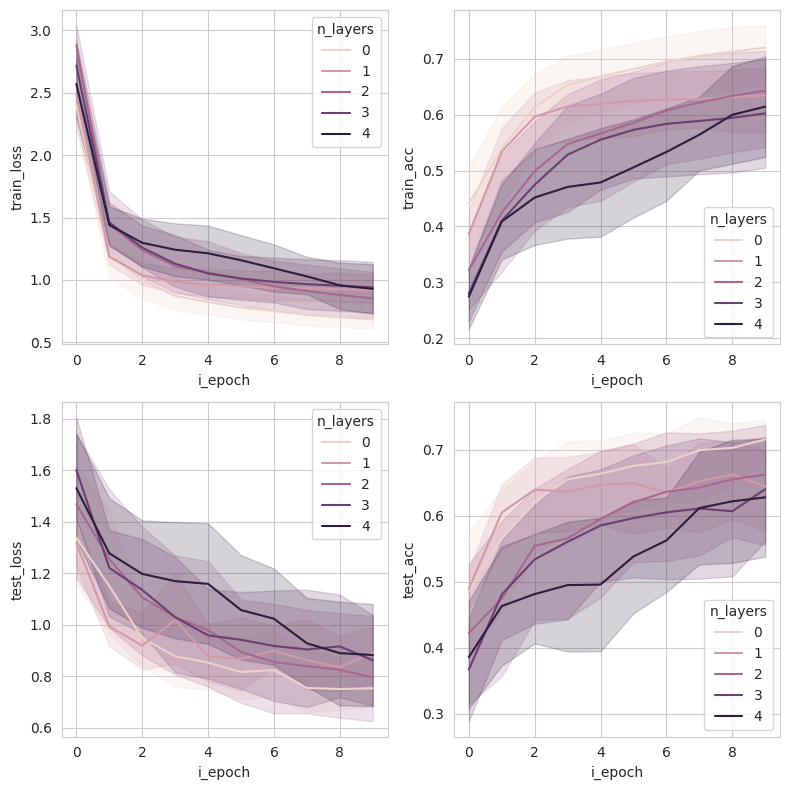

In [49]:
visualize_n_layers(df)

- Во всех случаях добавление скрытых слоев ухудшает качество и лосс (чем больше скрытых слоев, тем хуже)
- При этом эффект переобучения не наблюдается при любом количестве слоев (метрика на тесте во всех случаях даже немного лучше, чем на трейне)

Может быть дело в слишком малой скрытой размерности (т.е. мб преобразования в пространстве малой размерности слишком неточные)

In [50]:
df = do_exp_n_layers(hidden_size=96, n_tries=5, n_layers_list=[0, 1, 2, 3, 4])

try #0


epoch: 100%|██████████| 10/10 [04:15<00:00, 25.50s/it]


try #1


epoch: 100%|██████████| 10/10 [04:15<00:00, 25.53s/it]


try #2


epoch: 100%|██████████| 10/10 [04:17<00:00, 25.76s/it]


try #3


epoch: 100%|██████████| 10/10 [04:16<00:00, 25.67s/it]


try #4


epoch: 100%|██████████| 10/10 [04:16<00:00, 25.62s/it]


n_layers
0    50
1    50
2    50
3    50
4    50
Name: count, dtype: int64


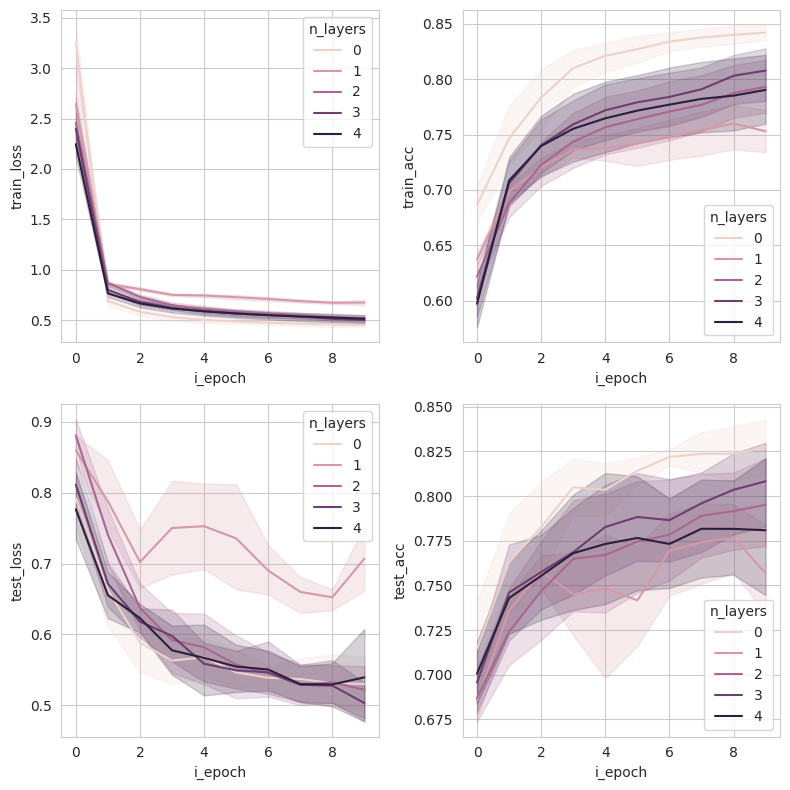

In [52]:
print(df.n_layers.value_counts())
visualize_n_layers(df)

- метрика во всех случаях немного поднялась
- со скрытыми слоями по-прежнему хуже, чем без них
- если до этого метрика выстраивала модели в ряд 0>1>2>3>4 (число означает число скрытых слоев), то теперь ряд 0>3>2>4>1

Ещё повысим скрытую размерность:

try #0


epoch: 100%|██████████| 10/10 [04:19<00:00, 25.94s/it]


try #1


epoch: 100%|██████████| 10/10 [04:15<00:00, 25.59s/it]


try #2


epoch: 100%|██████████| 10/10 [04:15<00:00, 25.53s/it]


try #3


epoch: 100%|██████████| 10/10 [04:13<00:00, 25.32s/it]


try #4


epoch: 100%|██████████| 10/10 [04:15<00:00, 25.53s/it]


n_layers
0    50
1    50
2    50
3    50
4    50
Name: count, dtype: int64


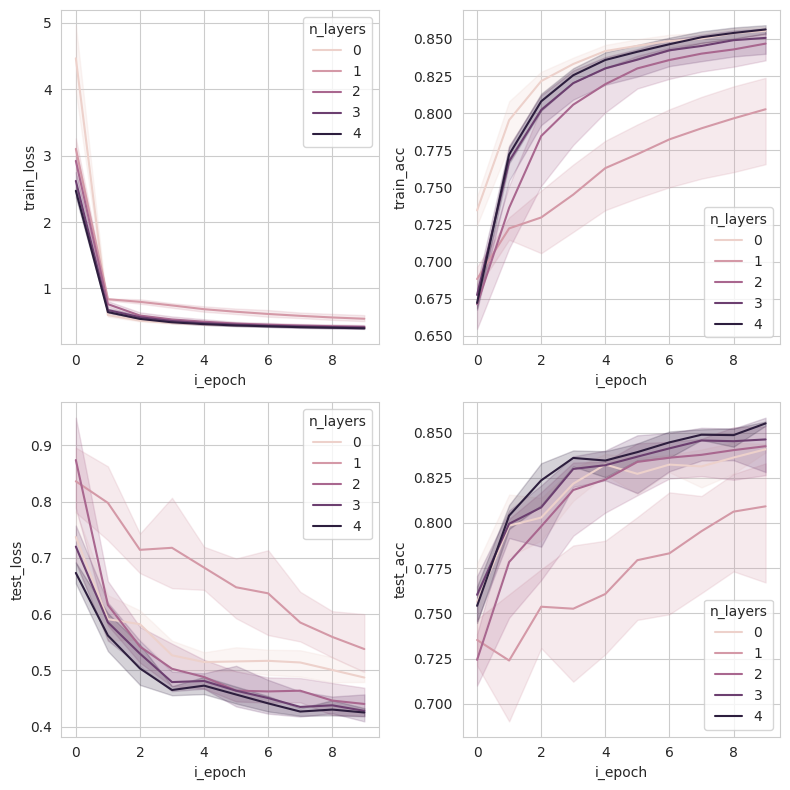

In [53]:
df = do_exp_n_layers(hidden_size=192, n_tries=5, n_layers_list=[0, 1, 2, 3, 4])
print(df.n_layers.value_counts())
visualize_n_layers(df)

- теперь 4>3>2>0>1
- переобучение по-прежнему отсутствует

## 4. Бонусная часть.

### 4.1 Реализация метода оптимизации (3 + 3 балла).
Реализуйте сами метод оптимизации  для рассмотренной выше архитектуры. Вы можете выбрать произвольный метод от градиентного спуска до современных вариантов. Продемонстрируйте правильную работу метода оптимизации, сравните его работы с Adam.

**Дополнительные баллы** вы получите, если метод будет уникален среди сдавших задание.

In [43]:
class AdamW(Optimizer):
    """
    Inspiration came from here: https://github.com/huggingface/transformers/blob/v4.33.3/src/transformers/optimization.py#L378
    """

    def __init__(
        self,
        params,
        lr=1e-3,
        betas=(0.9, 0.999),
        eps=1e-6,
        weight_decay=0.0,
        correct_bias=True,
    ):
        defaults = {
            "lr": lr,
            "betas": betas,
            "eps": eps,
            "weight_decay": weight_decay,
            "correct_bias": correct_bias
        }
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        loss = None
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad

                state = self.state[p]
                if len(state) == 0:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(p)
                    state["exp_avg_sq"] = torch.zeros_like(p)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]

                state["step"] += 1

                # update the first and second moment ema
                exp_avg.mul_(beta1).add_(grad, alpha=(1.0 - beta1))
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1.0 - beta2)
                denom = exp_avg_sq.sqrt().add_(group["eps"])

                # math expectation bias correction
                step_size = group["lr"]
                if group["correct_bias"]:
                    bias_correction1 = 1.0 - beta1 ** state["step"]
                    bias_correction2 = 1.0 - beta2 ** state["step"]
                    step_size = step_size * math.sqrt(bias_correction2) / bias_correction1

                # optimization step
                p.addcdiv_(exp_avg, denom, value=-step_size)

                # adamw-style weight decay
                if group["weight_decay"] > 0.0:
                    p.add_(p, alpha=(-group["lr"] * group["weight_decay"]))

        return loss

In [44]:
def configue_optimizer(model, config, optim):
    """
    Inspiration came from here: https://github.com/karpathy/minGPT/blob/master/mingpt/model.py#L215
    """
    decay = set()
    no_decay = set()
    for pn, p in model.named_parameters():
        if pn.endswith('bias'):
            no_decay.add(pn)
        elif pn.endswith('weight'):
            decay.add(pn)
    param_dict = {pn: p for pn, p in model.named_parameters()}
    inter_params = decay & no_decay
    union_params = decay | no_decay
    assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
    assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                % (str(param_dict.keys() - union_params), )
    optim_groups = [
        {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": config['weight_decay']},
        {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
    ]
    optimizer = optim(optim_groups, lr=config['lr'], betas=config['betas'])
    return optimizer

In [56]:
def optim_experiment(optim, decouple=False):
    model = Network(n_hidden_layers=4, hidden_size=192)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = AdamW if decouple else Adam
    config = {
        'lr': 5e-4,
        'betas': (0.9, 0.999),
        'weight_decay': 1e-2
    }
    optimizer = configue_optimizer(model, config, optim)
    criterion = CrossEntropy(reduction='mean')

    res = defaultdict(list)

    for i_epoch in tqdm(range(10), desc='epoch'):
        loss, acc = perform_epoch(
            model,
            train_dataloader,
            criterion,
            optimizer=optimizer,
            device=device
        )
        res['train_loss'].append(loss)
        res['train_acc'].append(acc)
        loss, acc = perform_epoch(
            model,
            test_dataloader,
            criterion,
            optimizer=None,
            device=device
        )
        res['test_loss'].append(loss)
        res['test_acc'].append(acc)
        res['i_epoch'].append(i_epoch)
    return res

In [ ]:
def do_exp_optim(n_tries):
    df = []
    for _ in n_tries:
        adam_res = optim_experiment(Adam, decouple=False)
        adamw_res = optim_experiment(AdamW, decouple=True)
        adam_res['decouple'] = [False] * 10
        adamw_res['decouple'] = [True] * 10
        df.append(pd.concat([pd.DataFrame(adam_res), pd.DataFrame(adamw_res)],  ignore_index=True))

    df = pd.concat(df, ignore_index=True)

    fig, ax = plt.subplots(2, 2, figsize=(8, 8))
    sns.lineplot(data=df, x='i_epoch', y='train_loss', hue='decouple', ax=ax[0, 0])
    sns.lineplot(data=df, x='i_epoch', y='train_acc', hue='decouple', ax=ax[0, 1])
    sns.lineplot(data=df, x='i_epoch', y='test_loss', hue='decouple', ax=ax[1, 0])
    sns.lineplot(data=df, x='i_epoch', y='test_acc', hue='decouple', ax=ax[1, 1])
    plt.show()

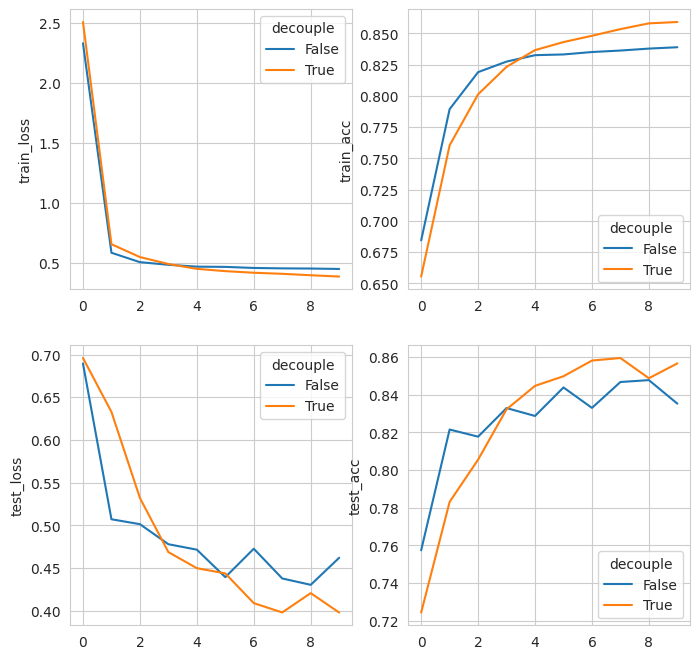

In [59]:
do_exp_optim()

Использование AdamW уменьшает лосс и увеличивает метрику качества

### 4.2 Реализация современной функции активации (2 + 2 балла).
Реализуйте одну из активаций, предложенных на лекции или в статье. Например, `Hardswish`. Сравните сеть с вашей активацией и с `ReLU`.

**Дополнительные баллы** вы получите, если функция будет уникальна среди сдавших задание.

In [46]:
class SiLUFunction(Function):
    @staticmethod
    def forward(ctx, input):
        sigmoid = nn.functional.sigmoid(input)
        output = input * sigmoid
        ctx.save_for_backward(input, sigmoid)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, sigmoid = ctx.saved_tensors
        grad_f_x = sigmoid * (1 + input * (1 - sigmoid))
        grad_input = grad_f_x * grad_output
        return grad_input

class SiLU(nn.Module):
    def __init__(self):
        super().__init__()

        self.fn = SiLUFunction.apply

    def forward(self, input):
        return self.fn(input)

In [47]:
class HardswishFunction(Function):
    @staticmethod
    def forward(ctx, input):
        mask_left = (-3 > input)
        output = torch.where(mask_left, 0, input)
        mask_inner = (~mask_left) & (input < 3)
        tmp = output[mask_inner]
        output[mask_inner] = tmp * (tmp + 3) / 6
        ctx.save_for_backward(mask_left, mask_inner, input)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        mask_left, mask_inner, input = ctx.saved_tensors
        relu6 = input + 3
        relu6[mask_left] = 0
        relu6[~(mask_inner|mask_left)] = 1
        tmp = input * mask_inner
        grad_f_x = (relu6 + tmp) / 6
        grad_input = grad_f_x * grad_output
        return grad_input

class Hardswish(nn.Module):
    def __init__(self):
        super().__init__()

        self.fn = HardswishFunction.apply

    def forward(self, input):
        return self.fn(input)

In [48]:
from typing import Literal


class Network(nn.Module):
    def __init__(
        self,
        input_size=28*28,
        hidden_size=32,
        n_hidden_layers=1,
        n_classes=10,
        dropout_prob=0.05,
        act_fn: Literal['silu', 'hardswish', 'relu'] = 'relu'
    ):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_hidden_layers = n_hidden_layers
        self.n_classes = n_classes

        self.input_layer = Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([Linear(hidden_size, hidden_size) for _ in range(n_hidden_layers)])
        self.drop = nn.ModuleList([Dropout(dropout_prob) for _ in range(n_hidden_layers)])
        self.output_layer = Linear(hidden_size, n_classes)

        if act_fn == 'silu':
            self.act_fn = SiLU()
        elif act_fn == 'hardswish':
            self.act_fn = Hardswish()
        elif act_fn == 'relu':
            self.act_fn = ReLU()
        else:
            raise ValueError(f'unknown activation function {act_fn}')
        
        self.log_softmax = LogSoftmax()

    def forward(self, x):
        x = x.reshape(len(x), -1)
        x = self.act_fn(self.input_layer(x))
        for layer, drop in zip(self.hidden_layers, self.drop):
            x = self.act_fn(layer(drop(x)))
        x = self.output_layer(x)
        x = self.log_softmax(x)
        return x

    def predict(self, x):
        logits = self(x)
        pred_labels = torch.argmax(logits, dim=1)
        return pred_labels

In [55]:
from collections import defaultdict
from tqdm.autonotebook import tqdm


def act_fn_experiment(act_fn):
    model = Network(n_hidden_layers=0, hidden_size=192, act_fn=act_fn)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    config = {
        'lr': 5e-4,
        'betas': (0.9, 0.999),
        'weight_decay': 1e-2
    }
    optimizer = configue_optimizer(model, config, AdamW)
    criterion = CrossEntropy(reduction='mean')

    res = defaultdict(list)

    for i_epoch in tqdm(range(10), desc='epoch'):
        loss, acc = perform_epoch(
            model,
            train_dataloader,
            criterion,
            optimizer=optimizer,
            device=device
        )
        res['train_loss'].append(loss)
        res['train_acc'].append(acc)
        loss, acc = perform_epoch(
            model,
            test_dataloader,
            criterion,
            optimizer=None,
            device=device
        )
        res['test_loss'].append(loss)
        res['test_acc'].append(acc)
        res['i_epoch'].append(i_epoch)
    return res

In [58]:
def seed_everything(seed: int):
    """https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964"""
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [61]:
seed_everything(42)
res_silu = act_fn_experiment('silu')

epoch: 100%|██████████| 10/10 [01:43<00:00, 10.40s/it]


In [62]:
seed_everything(42)
res_hardswish = act_fn_experiment('hardswish')

epoch: 100%|██████████| 10/10 [02:12<00:00, 13.26s/it]


In [63]:
seed_everything(42)
res_relu = act_fn_experiment('relu')

epoch: 100%|██████████| 10/10 [01:42<00:00, 10.25s/it]


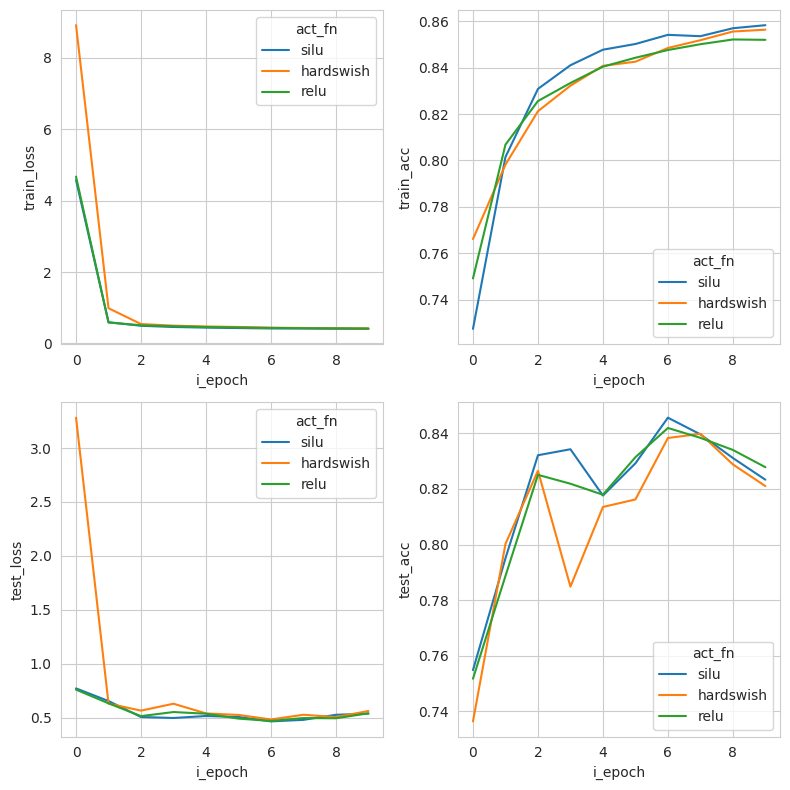

In [70]:
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt


df_silu = pd.DataFrame(res_silu)
df_hardswish = pd.DataFrame(res_hardswish)
df_relu = pd.DataFrame(res_relu)

df_silu['act_fn'] = 'silu'
df_hardswish['act_fn'] = 'hardswish'
df_relu['act_fn'] = 'relu'

df = pd.concat([df_silu, df_hardswish, df_relu])

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.lineplot(data=df, x='i_epoch', y='train_loss', hue='act_fn', ax=ax[0, 0])
sns.lineplot(data=df, x='i_epoch', y='train_acc', hue='act_fn', ax=ax[0, 1])
sns.lineplot(data=df, x='i_epoch', y='test_loss', hue='act_fn', ax=ax[1, 0])
sns.lineplot(data=df, x='i_epoch', y='test_acc', hue='act_fn', ax=ax[1, 1])
plt.tight_layout()

Существенной разницы в итоговых лоссах и метриках не наблюдается, но кривые обучения выглядят по-разному